In [1]:
import os, tqdm

In [2]:
from sklearn.metrics import r2_score
import numpy as np

# metric
def metric(label, pred):
    assert label.shape == pred.shape
    
    with np.errstate(divide = 'ignore', invalid = 'ignore'):
        mask = (label == label) & (pred == pred)
        mask = mask.astype(np.float32)
        mask /= np.mean(mask)
        
        male = np.abs(np.subtract(np.log(pred), np.log(label))).astype(np.float32)
        mae = np.abs(np.subtract(pred, label)).astype(np.float32)
        
        male = np.nan_to_num(male * mask)
        male = np.mean(male)
        
        mae = np.nan_to_num(mae * mask)
        mae = np.mean(mae)
        
        rmse = np.square(mae)
        rmse = np.nan_to_num(rmse * mask)
        rmse = np.sqrt(np.mean(rmse))
        
        mape = np.divide(mae, label)
        mape = np.nan_to_num(mape * mask)
        mape = np.median(mape*mask)
        
        print('masked:', np.sum(mask == 0))
    return male, rmse, mape

In [3]:
os.listdir('.')

['house-dataset-osm-road2vec-poa.ipynb',
 'house-dataset-feat-kde-fc-kc-poa-sp.ipynb',
 'mygeometries.py',
 'house-dataset-osm-neighbor-sp.ipynb',
 'house-dataset-osm-neighbor-kc-process.ipynb',
 '.ipynb_checkpoints',
 'brazil_data',
 'osmnx-1.3.0.zip',
 'house-dataset-feat-kde-fc-kc-poa-sp-mapviz.html',
 'house-dataset-feat-kde-fc-kc-poa-sp-mapviz.ipynb',
 'house-dataset-osm-AREA-EMBEDDING-sp.ipynb',
 'house-dataset-osm-road2vec-kc-POI-extraction.ipynb',
 'house-dataset-osm-sp-NodeEmbedding.ipynb',
 'house-dataset-osm-poa-NodeEmbedding.ipynb',
 'house-dataset-osm-AREA-EMBEDDING-kc.ipynb',
 'house-dataset-osm-road2vec-sp-POI-extraction.ipynb',
 'house-dataset-POI-sp.ipynb',
 'house-dataset-osm-neighbor-kc-process-Copy1.ipynb',
 'house-dataset-osm-kc-NodeEmbedding.ipynb',
 'osm_poi',
 'generateSE.py',
 'house-dataset-feat-kde+gaussianem_important-datagen-same-cluster.ipynb',
 'house-dataset-osm-road2vec-fc-POI-extraction.ipynb',
 'test-neighbor-mean-value.ipynb',
 'house-dataset-osm-roa

In [4]:
import numpy as np

In [5]:
streetmap = {
    'style': 'mapbox://styles/mapbox/streets-v9',
    'token': 'pk.eyJ1IjoiaHNtNjkxMSIsImEiOiJjazl0and6aDUwOWF2M2RvemdrYjllczV3In0.qGmaAF6v-1LAF9C-dnMLBg'
}
mybasemap = {
    #'style': 'mapbox://styles/mapbox/streets-v9',
    'style': 'mapbox://styles/mapbox/satellite-v9',
    'token': 'pk.eyJ1IjoiaHNtNjkxMSIsImEiOiJjazl0and6aDUwOWF2M2RvemdrYjllczV3In0.qGmaAF6v-1LAF9C-dnMLBg'
}

In [6]:
from cartoframes.viz import *

Note: NumExpr detected 64 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
NumExpr defaulting to 8 threads.


In [7]:
import pandas as pd

In [8]:
import geopandas as gpd

In [9]:
dname = 'fc'

In [10]:
print(dname)
data = np.load(f'{dname}/data.npz')

dict1 = {'lat':data['X_train'][:,0], 'lng': data['X_train'][:,1], 'price': data['y_train']}
dict2 = {'lat':data['X_test'][:,0], 'lng': data['X_test'][:,1], 'price': data['y_test']}
attr_names = []
for a in range(2, data['X_train'].shape[1]):
    dict1.update({f'attr{a-2}': data['X_train'][:, a]})
    dict2.update({f'attr{a-2}': data['X_test'][:, a]})
    attr_names.append(f'attr{a-2}')
df1 = pd.DataFrame(dict1)
df2 = pd.DataFrame(dict2)
df = pd.concat([df1, df2])

train_gdf = gpd.GeoDataFrame(df1.copy(), geometry=gpd.points_from_xy(x=df1.lng, y=df1.lat))
train_gdf.crs = 'EPSG:4326'
test_gdf = gpd.GeoDataFrame(df2.copy(), geometry=gpd.points_from_xy(x=df2.lng, y=df2.lat))
test_gdf.crs = 'EPSG:4326'
house_gdf = gpd.GeoDataFrame(df.copy(), geometry=gpd.points_from_xy(x=df.lng, y=df.lat))
house_gdf.crs = 'EPSG:4326'
#print(np.exp(df['price'].values).mean())
gdf = house_gdf
for attr in attr_names:
    print(attr, gdf[attr].nunique())
    if gdf[attr].nunique() < 30:
        gdf[attr] = gdf[attr].astype(str)
gdfcpy = gdf.copy()


#     display(Map(
#         [
#             Layer(gdfcpy, color_category_style(tattr, cat=cat, palette='cb_blues'), encode_data=False),
#             Layer(gdf, color_continuous_style('price', palette='sunset'), encode_data=False),
#         ],
#         basemap=mybasemap))

fc
attr0 6447
attr1 18
attr2 11
attr3 6447
attr4 16372
attr5 79
attr6 3230
attr7 8
attr8 6


In [11]:
import osmnx as ox
from shapely.geometry import *

if not os.path.isdir('osmdata'):
    os.mkdir('osmdata')
    
DATASET_NAME = dname
OSM_FILE_PATH = f'osmdata/{DATASET_NAME}.graphml'

from shapely.geometry import MultiPoint


x1, y1, x2, y2 = gdf.total_bounds

house_center_latitude = (y1 + y2)/2 #sensor_hull.centroid.y
house_center_longitude = (x1 + x2)/2 #sensor_hull.centroid.x

     
graphs = dict()
# retrieve the street network for the location
if not os.path.isfile(OSM_FILE_PATH):
    center_point = gpd.GeoDataFrame(geometry = [Point(house_center_longitude, house_center_latitude)])
    center_point.crs = 'epsg:4326'
    center_point = center_point.to_crs('epsg:3310')
    max_distance = gdf.to_crs('epsg:3310').distance(center_point.iloc[0].geometry).max()+1000
    print('max_distance:', max_distance)
    graph = ox.graph_from_point((house_center_latitude, house_center_longitude), dist=max_distance)

    # save the street network to a shapefile
    ox.save_graphml(graph, filepath=OSM_FILE_PATH)
else:
    graph = ox.load_graphml(filepath=OSM_FILE_PATH)
    


In [12]:
osm_nodes, osm_edges = ox.graph_to_gdfs(graph)

In [13]:
osm_nodes['osmidn'] = osm_nodes.index
osm_nodes['osmidstr'] = osm_nodes['osmidn'].astype(str)
osm_edges = osm_edges.reset_index()
cond = np.array([str(type(s)) for s in osm_edges['highway']]) == "<class 'str'>"
osm_edges = osm_edges[cond]

100%|█████████████████████████████████| 182508/182508 [02:38<00:00, 1153.33it/s]


In [83]:
minx, miny, maxx, maxy = house_gdf.total_bounds + np.array([-0.01, -0.01, +0.01, +0.01])
ncols = 100
nrows = 100 #int(ncols * (maxy - miny) / (maxx - minx) * 1.2)
nwidth = (maxx - minx) / ncols
nheight = (maxy - miny) / nrows
#(maxy - miny) / (maxx - minx)

from shapely import box
geos = []
for j in range(nrows):
    for i in range(ncols):
        x1 = minx + nwidth*i
        x2 = minx + nwidth*(i+1)
        y1 = miny + nheight*j
        y2 = miny + nheight*(j+1)
        
        geos.append(box(x1, y1, x2, y2))
        
grid_gdf = gpd.GeoDataFrame(geometry=geos)

fosm_edges = osm_edges[osm_edges.intersects(box(minx, miny, maxx, maxy))]

grid_num = len(grid_gdf)

###############
import tqdm
adj_mx = np.zeros((grid_num, grid_num))
for road_geo in tqdm.tqdm(fosm_edges.geometry, total=len(fosm_edges)):
    connect_list = grid_gdf[grid_gdf.intersects(road_geo)].index
    for i in range(len(connect_list)):
        for j in range(i+1, len(connect_list)):
            ii = connect_list[i]
            jj = connect_list[j]
            adj_mx[jj, ii] += 1
            
            
##############

import node2vec
import numpy as np
import networkx as nx
from gensim.models import Word2Vec

with open(f'{dname}/Adj-grid.txt', 'w') as fp:
    for i in range(grid_num):
        for j in range(grid_num):
            if adj_mx[i, j] > 0:
                fp.write(f'{i} {j} {adj_mx[i, j]}\n')

def read_graph(edgelist):
    G = nx.read_edgelist(
        edgelist, nodetype=str, data=(('weight',float),),
        create_using=nx.DiGraph())
    return G

Adj_file = f'{dname}/Adj-grid.txt'
nx_G = read_graph(Adj_file)

num_walks = 1000
walk_length = 20
p = 1000
q = 1
is_directed = True

G = node2vec.Graph(nx_G, is_directed, p, q)
G.preprocess_transition_probs()
node2vec_walks = G.simulate_walks(num_walks, walk_length)



from gensim.models import Word2Vec

vector_size = 64
sentences = node2vec_walks
model_node = Word2Vec(sentences, window=7, min_count=0, workers=64, vector_size=vector_size)


vectors = []
for gid in range(grid_num):
    gid = str(gid)
    if gid in model_node.wv:
        vectors.append(model_node.wv[gid])
    else:
        vectors.append(np.zeros(vector_size))
vectors = np.array(vectors)
np.save(f'{dname}/grid_vectors.npy', vectors)

100%|█████████████████████████████████| 182508/182508 [02:36<00:00, 1167.91it/s]


Walk iteration:
1 / 1000
2 / 1000
3 / 1000
4 / 1000
5 / 1000
6 / 1000
7 / 1000
8 / 1000
9 / 1000
10 / 1000
11 / 1000
12 / 1000
13 / 1000
14 / 1000
15 / 1000
16 / 1000
17 / 1000
18 / 1000
19 / 1000
20 / 1000
21 / 1000
22 / 1000
23 / 1000
24 / 1000
25 / 1000
26 / 1000
27 / 1000
28 / 1000
29 / 1000
30 / 1000
31 / 1000
32 / 1000
33 / 1000
34 / 1000
35 / 1000
36 / 1000
37 / 1000
38 / 1000
39 / 1000
40 / 1000
41 / 1000
42 / 1000
43 / 1000
44 / 1000
45 / 1000
46 / 1000
47 / 1000
48 / 1000
49 / 1000
50 / 1000
51 / 1000
52 / 1000
53 / 1000
54 / 1000
55 / 1000
56 / 1000
57 / 1000
58 / 1000
59 / 1000
60 / 1000
61 / 1000
62 / 1000
63 / 1000
64 / 1000
65 / 1000
66 / 1000
67 / 1000
68 / 1000
69 / 1000
70 / 1000
71 / 1000
72 / 1000
73 / 1000
74 / 1000
75 / 1000
76 / 1000
77 / 1000
78 / 1000
79 / 1000
80 / 1000
81 / 1000
82 / 1000
83 / 1000
84 / 1000
85 / 1000
86 / 1000
87 / 1000
88 / 1000
89 / 1000
90 / 1000
91 / 1000
92 / 1000
93 / 1000
94 / 1000
95 / 1000
96 / 1000
97 / 1000
98 / 1000
99 / 1000
100

755 / 1000
756 / 1000
757 / 1000
758 / 1000
759 / 1000
760 / 1000
761 / 1000
762 / 1000
763 / 1000
764 / 1000
765 / 1000
766 / 1000
767 / 1000
768 / 1000
769 / 1000
770 / 1000
771 / 1000
772 / 1000
773 / 1000
774 / 1000
775 / 1000
776 / 1000
777 / 1000
778 / 1000
779 / 1000
780 / 1000
781 / 1000
782 / 1000
783 / 1000
784 / 1000
785 / 1000
786 / 1000
787 / 1000
788 / 1000
789 / 1000
790 / 1000
791 / 1000
792 / 1000
793 / 1000
794 / 1000
795 / 1000
796 / 1000
797 / 1000
798 / 1000
799 / 1000
800 / 1000
801 / 1000
802 / 1000
803 / 1000
804 / 1000
805 / 1000
806 / 1000
807 / 1000
808 / 1000
809 / 1000
810 / 1000
811 / 1000
812 / 1000
813 / 1000
814 / 1000
815 / 1000
816 / 1000
817 / 1000
818 / 1000
819 / 1000
820 / 1000
821 / 1000
822 / 1000
823 / 1000
824 / 1000
825 / 1000
826 / 1000
827 / 1000
828 / 1000
829 / 1000
830 / 1000
831 / 1000
832 / 1000
833 / 1000
834 / 1000
835 / 1000
836 / 1000
837 / 1000
838 / 1000
839 / 1000
840 / 1000
841 / 1000
842 / 1000
843 / 1000
844 / 1000
845 / 1000

PROGRESS: at sentence #690000, processed 6466598 words, keeping 8147 word types
PROGRESS: at sentence #700000, processed 6559940 words, keeping 8147 word types
PROGRESS: at sentence #710000, processed 6653991 words, keeping 8147 word types
PROGRESS: at sentence #720000, processed 6747139 words, keeping 8147 word types
PROGRESS: at sentence #730000, processed 6840652 words, keeping 8147 word types
PROGRESS: at sentence #740000, processed 6934223 words, keeping 8147 word types
PROGRESS: at sentence #750000, processed 7027756 words, keeping 8147 word types
PROGRESS: at sentence #760000, processed 7120739 words, keeping 8147 word types
PROGRESS: at sentence #770000, processed 7213982 words, keeping 8147 word types
PROGRESS: at sentence #780000, processed 7308073 words, keeping 8147 word types
PROGRESS: at sentence #790000, processed 7401599 words, keeping 8147 word types
PROGRESS: at sentence #800000, processed 7495386 words, keeping 8147 word types
PROGRESS: at sentence #810000, processed

PROGRESS: at sentence #1700000, processed 15933177 words, keeping 8147 word types
PROGRESS: at sentence #1710000, processed 16026656 words, keeping 8147 word types
PROGRESS: at sentence #1720000, processed 16119827 words, keeping 8147 word types
PROGRESS: at sentence #1730000, processed 16214259 words, keeping 8147 word types
PROGRESS: at sentence #1740000, processed 16307403 words, keeping 8147 word types
PROGRESS: at sentence #1750000, processed 16401818 words, keeping 8147 word types
PROGRESS: at sentence #1760000, processed 16495491 words, keeping 8147 word types
PROGRESS: at sentence #1770000, processed 16588979 words, keeping 8147 word types
PROGRESS: at sentence #1780000, processed 16682153 words, keeping 8147 word types
PROGRESS: at sentence #1790000, processed 16776690 words, keeping 8147 word types
PROGRESS: at sentence #1800000, processed 16869559 words, keeping 8147 word types
PROGRESS: at sentence #1810000, processed 16964245 words, keeping 8147 word types
PROGRESS: at sen

PROGRESS: at sentence #2700000, processed 25301521 words, keeping 8147 word types
PROGRESS: at sentence #2710000, processed 25395375 words, keeping 8147 word types
PROGRESS: at sentence #2720000, processed 25488321 words, keeping 8147 word types
PROGRESS: at sentence #2730000, processed 25582189 words, keeping 8147 word types
PROGRESS: at sentence #2740000, processed 25676431 words, keeping 8147 word types
PROGRESS: at sentence #2750000, processed 25769896 words, keeping 8147 word types
PROGRESS: at sentence #2760000, processed 25863630 words, keeping 8147 word types
PROGRESS: at sentence #2770000, processed 25957082 words, keeping 8147 word types
PROGRESS: at sentence #2780000, processed 26051840 words, keeping 8147 word types
PROGRESS: at sentence #2790000, processed 26145099 words, keeping 8147 word types
PROGRESS: at sentence #2800000, processed 26237969 words, keeping 8147 word types
PROGRESS: at sentence #2810000, processed 26331636 words, keeping 8147 word types
PROGRESS: at sen

PROGRESS: at sentence #3700000, processed 34670982 words, keeping 8147 word types
PROGRESS: at sentence #3710000, processed 34765133 words, keeping 8147 word types
PROGRESS: at sentence #3720000, processed 34857766 words, keeping 8147 word types
PROGRESS: at sentence #3730000, processed 34952471 words, keeping 8147 word types
PROGRESS: at sentence #3740000, processed 35045973 words, keeping 8147 word types
PROGRESS: at sentence #3750000, processed 35140029 words, keeping 8147 word types
PROGRESS: at sentence #3760000, processed 35233782 words, keeping 8147 word types
PROGRESS: at sentence #3770000, processed 35327105 words, keeping 8147 word types
PROGRESS: at sentence #3780000, processed 35420911 words, keeping 8147 word types
PROGRESS: at sentence #3790000, processed 35514844 words, keeping 8147 word types
PROGRESS: at sentence #3800000, processed 35608277 words, keeping 8147 word types
PROGRESS: at sentence #3810000, processed 35701880 words, keeping 8147 word types
PROGRESS: at sen

PROGRESS: at sentence #4700000, processed 44038647 words, keeping 8147 word types
PROGRESS: at sentence #4710000, processed 44132106 words, keeping 8147 word types
PROGRESS: at sentence #4720000, processed 44225740 words, keeping 8147 word types
PROGRESS: at sentence #4730000, processed 44319432 words, keeping 8147 word types
PROGRESS: at sentence #4740000, processed 44413539 words, keeping 8147 word types
PROGRESS: at sentence #4750000, processed 44507183 words, keeping 8147 word types
PROGRESS: at sentence #4760000, processed 44601072 words, keeping 8147 word types
PROGRESS: at sentence #4770000, processed 44696082 words, keeping 8147 word types
PROGRESS: at sentence #4780000, processed 44789297 words, keeping 8147 word types
PROGRESS: at sentence #4790000, processed 44883217 words, keeping 8147 word types
PROGRESS: at sentence #4800000, processed 44976794 words, keeping 8147 word types
PROGRESS: at sentence #4810000, processed 45070919 words, keeping 8147 word types
PROGRESS: at sen

PROGRESS: at sentence #5700000, processed 53414001 words, keeping 8147 word types
PROGRESS: at sentence #5710000, processed 53508231 words, keeping 8147 word types
PROGRESS: at sentence #5720000, processed 53601601 words, keeping 8147 word types
PROGRESS: at sentence #5730000, processed 53694472 words, keeping 8147 word types
PROGRESS: at sentence #5740000, processed 53787993 words, keeping 8147 word types
PROGRESS: at sentence #5750000, processed 53881969 words, keeping 8147 word types
PROGRESS: at sentence #5760000, processed 53975385 words, keeping 8147 word types
PROGRESS: at sentence #5770000, processed 54068751 words, keeping 8147 word types
PROGRESS: at sentence #5780000, processed 54162254 words, keeping 8147 word types
PROGRESS: at sentence #5790000, processed 54255837 words, keeping 8147 word types
PROGRESS: at sentence #5800000, processed 54350051 words, keeping 8147 word types
PROGRESS: at sentence #5810000, processed 54443660 words, keeping 8147 word types
PROGRESS: at sen

PROGRESS: at sentence #6700000, processed 62783974 words, keeping 8147 word types
PROGRESS: at sentence #6710000, processed 62877612 words, keeping 8147 word types
PROGRESS: at sentence #6720000, processed 62971274 words, keeping 8147 word types
PROGRESS: at sentence #6730000, processed 63064075 words, keeping 8147 word types
PROGRESS: at sentence #6740000, processed 63158379 words, keeping 8147 word types
PROGRESS: at sentence #6750000, processed 63251752 words, keeping 8147 word types
PROGRESS: at sentence #6760000, processed 63345696 words, keeping 8147 word types
PROGRESS: at sentence #6770000, processed 63439835 words, keeping 8147 word types
PROGRESS: at sentence #6780000, processed 63532948 words, keeping 8147 word types
PROGRESS: at sentence #6790000, processed 63626659 words, keeping 8147 word types
PROGRESS: at sentence #6800000, processed 63720336 words, keeping 8147 word types
PROGRESS: at sentence #6810000, processed 63814541 words, keeping 8147 word types
PROGRESS: at sen

PROGRESS: at sentence #7700000, processed 72159444 words, keeping 8147 word types
PROGRESS: at sentence #7710000, processed 72252783 words, keeping 8147 word types
PROGRESS: at sentence #7720000, processed 72346848 words, keeping 8147 word types
PROGRESS: at sentence #7730000, processed 72440325 words, keeping 8147 word types
PROGRESS: at sentence #7740000, processed 72535135 words, keeping 8147 word types
PROGRESS: at sentence #7750000, processed 72628944 words, keeping 8147 word types
PROGRESS: at sentence #7760000, processed 72722313 words, keeping 8147 word types
PROGRESS: at sentence #7770000, processed 72816438 words, keeping 8147 word types
PROGRESS: at sentence #7780000, processed 72909938 words, keeping 8147 word types
PROGRESS: at sentence #7790000, processed 73003725 words, keeping 8147 word types
PROGRESS: at sentence #7800000, processed 73098193 words, keeping 8147 word types
PROGRESS: at sentence #7810000, processed 73191678 words, keeping 8147 word types
PROGRESS: at sen

EPOCH 1 - PROGRESS: at 10.82% examples, 2740921 words/s, in_qsize 127, out_qsize 0
EPOCH 1 - PROGRESS: at 14.61% examples, 2776561 words/s, in_qsize 127, out_qsize 0
EPOCH 1 - PROGRESS: at 18.32% examples, 2788221 words/s, in_qsize 126, out_qsize 1
EPOCH 1 - PROGRESS: at 22.03% examples, 2791539 words/s, in_qsize 126, out_qsize 1
EPOCH 1 - PROGRESS: at 25.59% examples, 2781016 words/s, in_qsize 127, out_qsize 0
EPOCH 1 - PROGRESS: at 29.57% examples, 2810764 words/s, in_qsize 127, out_qsize 0
EPOCH 1 - PROGRESS: at 33.38% examples, 2821249 words/s, in_qsize 128, out_qsize 0
EPOCH 1 - PROGRESS: at 37.11% examples, 2823665 words/s, in_qsize 127, out_qsize 0
EPOCH 1 - PROGRESS: at 41.05% examples, 2838814 words/s, in_qsize 128, out_qsize 0
EPOCH 1 - PROGRESS: at 44.81% examples, 2837913 words/s, in_qsize 127, out_qsize 0
EPOCH 1 - PROGRESS: at 48.76% examples, 2848585 words/s, in_qsize 128, out_qsize 1
EPOCH 1 - PROGRESS: at 52.59% examples, 2852813 words/s, in_qsize 125, out_qsize 2
EPOC

EPOCH 4 - PROGRESS: at 75.37% examples, 2726204 words/s, in_qsize 128, out_qsize 0
EPOCH 4 - PROGRESS: at 79.00% examples, 2727911 words/s, in_qsize 126, out_qsize 1
EPOCH 4 - PROGRESS: at 82.57% examples, 2727764 words/s, in_qsize 127, out_qsize 0
EPOCH 4 - PROGRESS: at 86.15% examples, 2727934 words/s, in_qsize 127, out_qsize 0
EPOCH 4 - PROGRESS: at 89.73% examples, 2727902 words/s, in_qsize 127, out_qsize 0
EPOCH 4 - PROGRESS: at 93.43% examples, 2731375 words/s, in_qsize 127, out_qsize 0
EPOCH 4 - PROGRESS: at 97.08% examples, 2733127 words/s, in_qsize 127, out_qsize 0
EPOCH 4: training on 76351306 raw words (76351306 effective words) took 27.8s, 2749922 effective words/s
Word2Vec lifecycle event {'msg': 'training on 381756530 raw words (381756530 effective words) took 133.9s, 2850804 effective words/s', 'datetime': '2023-11-06T20:58:48.881594', 'gensim': '4.3.1', 'python': '3.10.8 | packaged by conda-forge | (main, Nov 22 2022, 08:26:04) [GCC 10.4.0]', 'platform': 'Linux-5.15.0-8

In [102]:
# from scipy import signal
# # mode='same' is there to enforce the same output shape as input arrays
# # (ie avoid border effects)

# img = vectors.reshape(100, 100, -1)
# img3 = signal.fftconvolve(img, kernel[:, :, np.newaxis], mode='same')

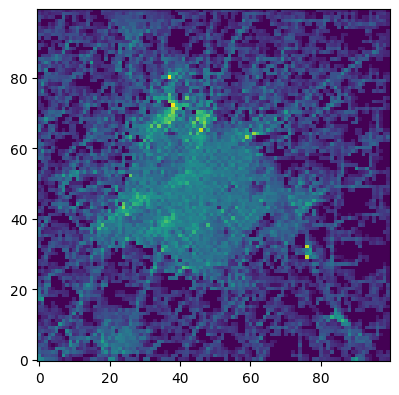

In [138]:
import numpy as np
from scipy.signal import convolve2d
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt
from scipy import misc

# Load an example RGB image (you can replace this with your own image)
image = vectors.reshape(100, 100, -1)#misc.face()

# Define the standard deviation for the Gaussian kernel
sigma = 1

# Create a Gaussian kernel using scipy's gaussian_filter
gaussian_kernel = gaussian_filter(np.eye(5), sigma)

# Normalize the kernel
gaussian_kernel /= gaussian_kernel.sum()

# Initialize an empty result image with the same shape as the input image
result = np.zeros_like(image)

# Apply 2D Gaussian convolution to each color channel separately
for channel in range(vector_size):
    result[:, :, channel] = convolve2d(image[:, :, channel], gaussian_kernel, mode='same', boundary='wrap')

# Plot the original RGB image and the convolved result
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)

mag = []
for row in image.reshape(-1, vector_size):
    mag.append(np.linalg.norm(row))
mag = np.array(mag).reshape(100, 100, 1)


# plt.imshow(image.mean(-1))

plt.imshow(mag)
plt.gca().invert_yaxis()


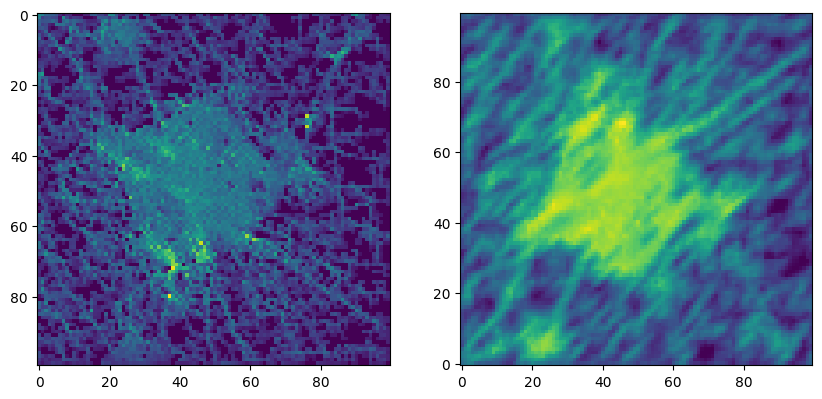

In [136]:
import numpy as np
from scipy.signal import convolve2d
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt
from scipy import misc

# Load an example RGB image (you can replace this with your own image)
image = vectors.reshape(100, 100, -1)#misc.face()

# Define the standard deviation for the Gaussian kernel
sigma = 1

# Create a Gaussian kernel using scipy's gaussian_filter
gaussian_kernel = gaussian_filter(np.eye(5), sigma)

# Normalize the kernel
gaussian_kernel /= gaussian_kernel.sum()

# Initialize an empty result image with the same shape as the input image
result = np.zeros_like(image)

# Apply 2D Gaussian convolution to each color channel separately
for channel in range(vector_size):
    result[:, :, channel] = convolve2d(image[:, :, channel], gaussian_kernel, mode='same', boundary='wrap')

# Plot the original RGB image and the convolved result
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)

mag = []
for row in image.reshape(-1, vector_size):
    mag.append(np.linalg.norm(row))
mag = np.array(mag).reshape(100, 100, 1)


# plt.imshow(image.mean(-1))
plt.gca().invert_yaxis()

plt.imshow(mag)
# plt.title('Original RGB Image')

mag = []
for row in result.reshape(-1, vector_size):
    mag.append(np.linalg.norm(row))
mag = np.array(mag).reshape(100, 100, 1)


plt.subplot(1, 2, 2)
plt.imshow(mag)
# plt.title('Gaussian Convolution')

plt.gca().invert_yaxis()

plt.show()
np.save(f'{dname}/grid_vectors_gaussian.npy', result.reshape(-1, vector_size))

In [120]:

import numpy as np

def positional_encoding_2d(grid_size, d_model):
    """
    Generate 2D positional encoding for a grid of given size and dimensions.
    
    Args:
        grid_size: Tuple (height, width) representing the grid size.
        d_model: The dimension of the positional encoding.
        
    Returns:
        A positional encoding matrix of shape (height, width, d_model).
    """
    height, width = grid_size
    pos_enc = np.zeros((height, width, d_model), np.float32)
    
    for pos in range(d_model):
        if pos % 2 == 0:
            pos_enc[:, :, pos] = np.sin(np.arange(0, height) / np.power(10000, 2 * pos / d_model))
        else:
            pos_enc[:, :, pos] = np.cos(np.arange(0, height) / np.power(10000, 2 * (pos - 1) / d_model))
    
    return pos_enc

In [123]:
image = positional_encoding_2d((100, 100), 64)

In [126]:
image[0, 0]

array([0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0.,
       1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1.,
       0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0.,
       1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1.], dtype=float32)

In [129]:
image[0, 3]

array([ 1.4112000e-01, -9.8999250e-01,  9.9325317e-01, -1.1596614e-01,
        8.1264889e-01,  5.8275360e-01,  5.0853616e-01,  8.6104065e-01,
        2.9552022e-01,  9.5533651e-01,  1.6790330e-01,  9.8580348e-01,
        9.4726093e-02,  9.9550337e-01,  5.3323079e-02,  9.9857730e-01,
        2.9995501e-02,  9.9955004e-01,  1.6869439e-02,  9.9985772e-01,
        9.4866911e-03,  9.9995500e-01,  5.3348131e-03,  9.9998575e-01,
        2.9999956e-03,  9.9999553e-01,  1.6870232e-03,  9.9999857e-01,
        9.4868318e-04,  9.9999952e-01,  5.3348381e-04,  9.9999988e-01,
        2.9999999e-04,  9.9999994e-01,  1.6870239e-04,  1.0000000e+00,
        9.4868330e-05,  1.0000000e+00,  5.3348384e-05,  1.0000000e+00,
        2.9999999e-05,  1.0000000e+00,  1.6870239e-05,  1.0000000e+00,
        9.4868328e-06,  1.0000000e+00,  5.3348381e-06,  1.0000000e+00,
        3.0000001e-06,  1.0000000e+00,  1.6870240e-06,  1.0000000e+00,
        9.4868329e-07,  1.0000000e+00,  5.3348384e-07,  1.0000000e+00,
      

In [132]:
image[3, 0]

array([0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0.,
       1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1.,
       0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0.,
       1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1.], dtype=float32)

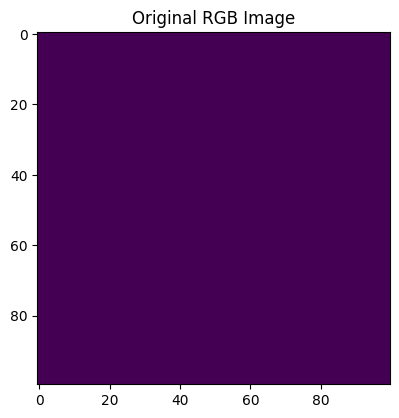

In [125]:

# Plot the original RGB image and the convolved result
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)

mag = []
for row in image.reshape(-1, vector_size):
    mag.append(np.linalg.norm(row))
mag = np.array(mag).reshape(100, 100, 1)


# plt.imshow(image.mean(-1))
plt.imshow(mag)
plt.title('Original RGB Image')

plt.show()
np.save(f'{dname}/grid_vectors_gaussian.npy', result.reshape(-1, vector_size))